In [3]:
import os
import json
import numpy as np
import cv2
import torch
from PIL import Image
from torchvision import transforms as T
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import segmentation_models_pytorch as smp 
import math

# --- 1. UTILITY AND LOSS DEFINITIONS (POLYGON MASKING) ---

def polygons_to_mask(image_shape, polygons):
    """Converts a list of polygon coordinates into a single-channel binary mask."""
    mask = np.zeros(image_shape, dtype=np.uint8) 
    for polygon in polygons:
        try:
            pts = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(mask, [pts], 1)
        except Exception:
            continue 
    return mask

def extract_polygons(annotation_structure):
    """Pulls polygon coordinates from a single image's annotation structure."""
    polygons = []
    groups = annotation_structure.get('groups', [])
    for item in groups:
        if isinstance(item, list):
            for annotation in item:
                verts = annotation.get('vertices')
                if verts:
                    polygons.append(verts)
        elif isinstance(item, dict):
            verts = item.get('vertices')
            if verts:
                polygons.append(verts)
    return polygons

class DiceLoss(nn.Module):
    """Computes the Sørensen–Dice Loss."""
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    def forward(self, input, target):
        input = torch.sigmoid(input) 
        input = input.view(-1)
        target = target.view(-1)
        intersection = (input * target).sum()                            
        dice = (2. * intersection + self.smooth) / (input.sum() + target.sum() + self.smooth)
        return 1 - dice


# --- 2. CUSTOM DATASET CLASS DEFINITION (MapOCRDataset) ---

class MapOCRDataset(torch.utils.data.Dataset):
    def __init__(self, data_root, image_folder, anno_filename, image_size=(640, 640)):
        
        # --- Data Setup (Loading JSON and creating lookup dictionary) ---
        self.image_dir = os.path.join(data_root, image_folder)
        self.image_size = image_size
        self.image_filenames = [f for f in os.listdir(self.image_dir) if f.endswith('.png')]
        
        anno_path = os.path.join(data_root, anno_filename) 
        with open(anno_path, 'r') as f:
            full_annotations_list = json.load(f) 

        self.full_annotations_dict = {}
        for anno_item in full_annotations_list:
            filename = anno_item.get('image') 
            if filename:
                self.full_annotations_dict[filename] = anno_item
        
        # --- Image Transformations ---
        self.transform = T.Compose([
            T.Resize(image_size),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_filename = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_filename)
        image = Image.open(image_path).convert("RGB")
        image_tensor = self.transform(image) 

        image_annotation_structure = self.full_annotations_dict.get(img_filename, {})
        polygons = extract_polygons(image_annotation_structure)
        
        mask_np = polygons_to_mask(self.image_size, polygons)
        mask_tensor = torch.from_numpy(mask_np).unsqueeze(0).float()
        
        return image_tensor, mask_tensor


# --- 3. DATA LOADING INITIALIZATION ---

DATA_ROOT = "Rumsey_Map_OCR_Data/rumsey/icdar24-train-png/"
IMAGE_FOLDER = "train_images"
ANNO_FILENAME = "annotations.json"
IMG_SIZE = (640, 640)
BATCH_SIZE = 4 

print("--- Data Loading Setup ---")
train_dataset = MapOCRDataset(
    data_root=DATA_ROOT,
    image_folder=IMAGE_FOLDER,
    anno_filename=ANNO_FILENAME,
    image_size=IMG_SIZE
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
print(f"✅ Dataset and DataLoader (Size: {len(train_loader)} batches) created.")


# --- 4. U-NET TRAINING LOOP ---

LEARNING_RATE = 1e-4  
EPOCHS_TO_RUN = 50 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_SAVE_PATH = "unet_resnet18_50_epochs.pth"

print(f"\n--- 🚀 Starting U-Net Training on {DEVICE} ({EPOCHS_TO_RUN} Epochs) ---")

# ARCHITECTURAL UPGRADE: U-Net with ResNet18 Encoder
model = smp.Unet(
    encoder_name="resnet18",      
    encoder_weights="imagenet",   
    in_channels=3,                
    classes=1,                    
).to(DEVICE)

# Combined Loss: BCE + Dice
bce_criterion = smp.losses.SoftBCEWithLogitsLoss()
dice_criterion = smp.losses.DiceLoss(mode='binary')
criterion = lambda y_pred, y_true: bce_criterion(y_pred, y_true) + dice_criterion(y_pred, y_true)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.train()

for epoch in range(EPOCHS_TO_RUN):
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"U-Net Epoch {epoch+1}/{EPOCHS_TO_RUN}")
    
    for images, masks in progress_bar:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        total_loss = criterion(outputs, masks)
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item()
        
        bce_part = bce_criterion(outputs, masks).item()
        dice_part = dice_criterion(outputs, masks).item()
        
        progress_bar.set_postfix(Total_Loss=total_loss.item(), Dice_Loss=dice_part, BCE_Loss=bce_part)

    avg_loss = epoch_loss / len(train_loader)
    print(f"✅ U-Net Epoch {epoch+1} Completed. Average Combined Loss: {avg_loss:.4f}")

torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"\n🎉 U-Net Training Complete! Model weights saved to: {MODEL_SAVE_PATH}")

--- Data Loading Setup ---
✅ Dataset and DataLoader (Size: 50 batches) created.

--- 🚀 Starting U-Net Training on cuda (50 Epochs) ---


U-Net Epoch 1/50: 100%|██████████| 50/50 [00:46<00:00,  1.07it/s, BCE_Loss=0.646, Dice_Loss=0.708, Total_Loss=1.35]


✅ U-Net Epoch 1 Completed. Average Combined Loss: 1.4629


U-Net Epoch 2/50: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s, BCE_Loss=0.61, Dice_Loss=0.662, Total_Loss=1.27] 


✅ U-Net Epoch 2 Completed. Average Combined Loss: 1.3337


U-Net Epoch 3/50: 100%|██████████| 50/50 [00:36<00:00,  1.35it/s, BCE_Loss=0.559, Dice_Loss=0.716, Total_Loss=1.28]


✅ U-Net Epoch 3 Completed. Average Combined Loss: 1.2767


U-Net Epoch 4/50: 100%|██████████| 50/50 [00:38<00:00,  1.30it/s, BCE_Loss=0.485, Dice_Loss=0.725, Total_Loss=1.21]


✅ U-Net Epoch 4 Completed. Average Combined Loss: 1.2296


U-Net Epoch 5/50: 100%|██████████| 50/50 [00:38<00:00,  1.29it/s, BCE_Loss=0.483, Dice_Loss=0.696, Total_Loss=1.18]


✅ U-Net Epoch 5 Completed. Average Combined Loss: 1.1611


U-Net Epoch 6/50: 100%|██████████| 50/50 [00:38<00:00,  1.29it/s, BCE_Loss=0.459, Dice_Loss=0.521, Total_Loss=0.98] 


✅ U-Net Epoch 6 Completed. Average Combined Loss: 1.0588


U-Net Epoch 7/50: 100%|██████████| 50/50 [00:38<00:00,  1.30it/s, BCE_Loss=0.459, Dice_Loss=0.485, Total_Loss=0.944]


✅ U-Net Epoch 7 Completed. Average Combined Loss: 0.9545


U-Net Epoch 8/50: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s, BCE_Loss=0.439, Dice_Loss=0.478, Total_Loss=0.918]


✅ U-Net Epoch 8 Completed. Average Combined Loss: 0.8486


U-Net Epoch 9/50: 100%|██████████| 50/50 [00:36<00:00,  1.36it/s, BCE_Loss=0.264, Dice_Loss=0.465, Total_Loss=0.729]


✅ U-Net Epoch 9 Completed. Average Combined Loss: 0.7569


U-Net Epoch 10/50: 100%|██████████| 50/50 [00:36<00:00,  1.36it/s, BCE_Loss=0.254, Dice_Loss=0.437, Total_Loss=0.691]


✅ U-Net Epoch 10 Completed. Average Combined Loss: 0.6918


U-Net Epoch 11/50: 100%|██████████| 50/50 [00:39<00:00,  1.28it/s, BCE_Loss=0.321, Dice_Loss=0.378, Total_Loss=0.699]


✅ U-Net Epoch 11 Completed. Average Combined Loss: 0.6092


U-Net Epoch 12/50: 100%|██████████| 50/50 [00:38<00:00,  1.31it/s, BCE_Loss=0.182, Dice_Loss=0.268, Total_Loss=0.451]


✅ U-Net Epoch 12 Completed. Average Combined Loss: 0.5420


U-Net Epoch 13/50: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s, BCE_Loss=0.179, Dice_Loss=0.222, Total_Loss=0.401]


✅ U-Net Epoch 13 Completed. Average Combined Loss: 0.4839


U-Net Epoch 14/50: 100%|██████████| 50/50 [00:38<00:00,  1.31it/s, BCE_Loss=0.211, Dice_Loss=0.291, Total_Loss=0.502]


✅ U-Net Epoch 14 Completed. Average Combined Loss: 0.4541


U-Net Epoch 15/50: 100%|██████████| 50/50 [00:38<00:00,  1.30it/s, BCE_Loss=0.176, Dice_Loss=0.192, Total_Loss=0.368]


✅ U-Net Epoch 15 Completed. Average Combined Loss: 0.4204


U-Net Epoch 16/50: 100%|██████████| 50/50 [00:38<00:00,  1.29it/s, BCE_Loss=0.119, Dice_Loss=0.188, Total_Loss=0.307]


✅ U-Net Epoch 16 Completed. Average Combined Loss: 0.3776


U-Net Epoch 17/50: 100%|██████████| 50/50 [00:39<00:00,  1.28it/s, BCE_Loss=0.122, Dice_Loss=0.194, Total_Loss=0.316] 


✅ U-Net Epoch 17 Completed. Average Combined Loss: 0.3554


U-Net Epoch 18/50: 100%|██████████| 50/50 [00:38<00:00,  1.29it/s, BCE_Loss=0.102, Dice_Loss=0.193, Total_Loss=0.295] 


✅ U-Net Epoch 18 Completed. Average Combined Loss: 0.3258


U-Net Epoch 19/50: 100%|██████████| 50/50 [00:39<00:00,  1.27it/s, BCE_Loss=0.0906, Dice_Loss=0.142, Total_Loss=0.233]


✅ U-Net Epoch 19 Completed. Average Combined Loss: 0.3004


U-Net Epoch 20/50: 100%|██████████| 50/50 [00:38<00:00,  1.29it/s, BCE_Loss=0.111, Dice_Loss=0.153, Total_Loss=0.264] 


✅ U-Net Epoch 20 Completed. Average Combined Loss: 0.2827


U-Net Epoch 21/50: 100%|██████████| 50/50 [00:39<00:00,  1.28it/s, BCE_Loss=0.138, Dice_Loss=0.152, Total_Loss=0.29]  


✅ U-Net Epoch 21 Completed. Average Combined Loss: 0.2551


U-Net Epoch 22/50: 100%|██████████| 50/50 [00:37<00:00,  1.35it/s, BCE_Loss=0.104, Dice_Loss=0.144, Total_Loss=0.248]  


✅ U-Net Epoch 22 Completed. Average Combined Loss: 0.2424


U-Net Epoch 23/50: 100%|██████████| 50/50 [00:36<00:00,  1.37it/s, BCE_Loss=0.0874, Dice_Loss=0.143, Total_Loss=0.231] 


✅ U-Net Epoch 23 Completed. Average Combined Loss: 0.2224


U-Net Epoch 24/50: 100%|██████████| 50/50 [00:36<00:00,  1.36it/s, BCE_Loss=0.105, Dice_Loss=0.133, Total_Loss=0.238]  


✅ U-Net Epoch 24 Completed. Average Combined Loss: 0.2164


U-Net Epoch 25/50: 100%|██████████| 50/50 [00:37<00:00,  1.32it/s, BCE_Loss=0.0553, Dice_Loss=0.0832, Total_Loss=0.138]


✅ U-Net Epoch 25 Completed. Average Combined Loss: 0.1993


U-Net Epoch 26/50: 100%|██████████| 50/50 [00:37<00:00,  1.32it/s, BCE_Loss=0.0842, Dice_Loss=0.114, Total_Loss=0.199] 


✅ U-Net Epoch 26 Completed. Average Combined Loss: 0.2005


U-Net Epoch 27/50: 100%|██████████| 50/50 [00:38<00:00,  1.30it/s, BCE_Loss=0.0878, Dice_Loss=0.103, Total_Loss=0.191] 


✅ U-Net Epoch 27 Completed. Average Combined Loss: 0.1851


U-Net Epoch 28/50: 100%|██████████| 50/50 [00:38<00:00,  1.30it/s, BCE_Loss=0.0748, Dice_Loss=0.0751, Total_Loss=0.15] 


✅ U-Net Epoch 28 Completed. Average Combined Loss: 0.1790


U-Net Epoch 29/50: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s, BCE_Loss=0.105, Dice_Loss=0.144, Total_Loss=0.248]  


✅ U-Net Epoch 29 Completed. Average Combined Loss: 0.1759


U-Net Epoch 30/50: 100%|██████████| 50/50 [01:11<00:00,  1.44s/it, BCE_Loss=0.0567, Dice_Loss=0.0946, Total_Loss=0.151]


✅ U-Net Epoch 30 Completed. Average Combined Loss: 0.1600


U-Net Epoch 31/50: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s, BCE_Loss=0.039, Dice_Loss=0.0867, Total_Loss=0.126] 


✅ U-Net Epoch 31 Completed. Average Combined Loss: 0.1543


U-Net Epoch 32/50: 100%|██████████| 50/50 [00:38<00:00,  1.29it/s, BCE_Loss=0.0468, Dice_Loss=0.102, Total_Loss=0.149] 


✅ U-Net Epoch 32 Completed. Average Combined Loss: 0.1530


U-Net Epoch 33/50: 100%|██████████| 50/50 [00:38<00:00,  1.29it/s, BCE_Loss=0.0692, Dice_Loss=0.0862, Total_Loss=0.155] 


✅ U-Net Epoch 33 Completed. Average Combined Loss: 0.1435


U-Net Epoch 34/50: 100%|██████████| 50/50 [00:38<00:00,  1.31it/s, BCE_Loss=0.0637, Dice_Loss=0.0699, Total_Loss=0.134] 


✅ U-Net Epoch 34 Completed. Average Combined Loss: 0.1385


U-Net Epoch 35/50: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s, BCE_Loss=0.0567, Dice_Loss=0.0524, Total_Loss=0.109] 


✅ U-Net Epoch 35 Completed. Average Combined Loss: 0.1355


U-Net Epoch 36/50: 100%|██████████| 50/50 [00:38<00:00,  1.31it/s, BCE_Loss=0.0679, Dice_Loss=0.0698, Total_Loss=0.138] 


✅ U-Net Epoch 36 Completed. Average Combined Loss: 0.1318


U-Net Epoch 37/50: 100%|██████████| 50/50 [00:38<00:00,  1.31it/s, BCE_Loss=0.0511, Dice_Loss=0.0786, Total_Loss=0.13]  


✅ U-Net Epoch 37 Completed. Average Combined Loss: 0.1253


U-Net Epoch 38/50: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, BCE_Loss=0.0621, Dice_Loss=0.072, Total_Loss=0.134]  


✅ U-Net Epoch 38 Completed. Average Combined Loss: 0.1234


U-Net Epoch 39/50: 100%|██████████| 50/50 [01:39<00:00,  1.99s/it, BCE_Loss=0.0589, Dice_Loss=0.0625, Total_Loss=0.121] 


✅ U-Net Epoch 39 Completed. Average Combined Loss: 0.1180


U-Net Epoch 40/50: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s, BCE_Loss=0.0498, Dice_Loss=0.0588, Total_Loss=0.109] 


✅ U-Net Epoch 40 Completed. Average Combined Loss: 0.1174


U-Net Epoch 41/50: 100%|██████████| 50/50 [00:38<00:00,  1.29it/s, BCE_Loss=0.0658, Dice_Loss=0.0704, Total_Loss=0.136] 


✅ U-Net Epoch 41 Completed. Average Combined Loss: 0.1148


U-Net Epoch 42/50: 100%|██████████| 50/50 [00:38<00:00,  1.30it/s, BCE_Loss=0.0484, Dice_Loss=0.0696, Total_Loss=0.118] 


✅ U-Net Epoch 42 Completed. Average Combined Loss: 0.1115


U-Net Epoch 43/50: 100%|██████████| 50/50 [00:38<00:00,  1.32it/s, BCE_Loss=0.0329, Dice_Loss=0.0473, Total_Loss=0.0802]


✅ U-Net Epoch 43 Completed. Average Combined Loss: 0.1066


U-Net Epoch 44/50: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s, BCE_Loss=0.0436, Dice_Loss=0.062, Total_Loss=0.106]  


✅ U-Net Epoch 44 Completed. Average Combined Loss: 0.1051


U-Net Epoch 45/50: 100%|██████████| 50/50 [00:36<00:00,  1.36it/s, BCE_Loss=0.0481, Dice_Loss=0.0546, Total_Loss=0.103] 


✅ U-Net Epoch 45 Completed. Average Combined Loss: 0.1020


U-Net Epoch 46/50: 100%|██████████| 50/50 [00:36<00:00,  1.37it/s, BCE_Loss=0.0331, Dice_Loss=0.0595, Total_Loss=0.0926]


✅ U-Net Epoch 46 Completed. Average Combined Loss: 0.1001


U-Net Epoch 47/50: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s, BCE_Loss=0.0486, Dice_Loss=0.0742, Total_Loss=0.123] 


✅ U-Net Epoch 47 Completed. Average Combined Loss: 0.0977


U-Net Epoch 48/50: 100%|██████████| 50/50 [00:36<00:00,  1.36it/s, BCE_Loss=0.0359, Dice_Loss=0.0487, Total_Loss=0.0846]


✅ U-Net Epoch 48 Completed. Average Combined Loss: 0.0958


U-Net Epoch 49/50: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s, BCE_Loss=0.0284, Dice_Loss=0.0395, Total_Loss=0.068] 


✅ U-Net Epoch 49 Completed. Average Combined Loss: 0.0942


U-Net Epoch 50/50: 100%|██████████| 50/50 [00:53<00:00,  1.07s/it, BCE_Loss=0.0405, Dice_Loss=0.0459, Total_Loss=0.0864]

✅ U-Net Epoch 50 Completed. Average Combined Loss: 0.0907

🎉 U-Net Training Complete! Model weights saved to: unet_resnet18_50_epochs.pth


In [2]:
import os
import json
import numpy as np
import cv2
import torch
from PIL import Image
from torchvision import transforms as T
import torch.nn as nn
import segmentation_models_pytorch as smp 
import matplotlib.pyplot as plt

# --- 1. UTILITY AND LOSS DEFINITIONS ---

def polygons_to_mask(image_shape, polygons):
    mask = np.zeros(image_shape, dtype=np.uint8) 
    for polygon in polygons:
        try:
            pts = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(mask, [pts], 1)
        except Exception:
            continue 
    return mask

def extract_polygons(annotation_structure):
    polygons = []
    groups = annotation_structure.get('groups', [])
    for item in groups:
        if isinstance(item, list):
            for annotation in item:
                verts = annotation.get('vertices')
                if verts:
                    polygons.append(verts)
        elif isinstance(item, dict):
            verts = item.get('vertices')
            if verts:
                polygons.append(verts)
    return polygons


# --- 2. CUSTOM DATASET CLASS DEFINITION (MapOCRDataset) ---

class MapOCRDataset(torch.utils.data.Dataset):
    def __init__(self, data_root, image_folder, anno_filename, image_size=(640, 640)):
        self.image_dir = os.path.join(data_root, image_folder)
        self.image_size = image_size
        self.image_filenames = [f for f in os.listdir(self.image_dir) if f.endswith('.png')]
        
        anno_path = os.path.join(data_root, anno_filename) 
        with open(anno_path, 'r') as f:
            full_annotations_list = json.load(f) 

        self.full_annotations_dict = {}
        for anno_item in full_annotations_list:
            filename = anno_item.get('image') 
            if filename:
                self.full_annotations_dict[filename] = anno_item
        
        self.transform = T.Compose([
            T.Resize(image_size),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_filename = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_filename)
        image = Image.open(image_path).convert("RGB")
        image_tensor = self.transform(image) 

        image_annotation_structure = self.full_annotations_dict.get(img_filename, {})
        polygons = extract_polygons(image_annotation_structure)
        
        mask_np = polygons_to_mask(self.image_size, polygons)
        mask_tensor = torch.from_numpy(mask_np).unsqueeze(0).float()
        
        return image_tensor, mask_tensor

print("✅ MapOCRDataset class and utilities defined.")

✅ MapOCRDataset class and utilities defined.


--- Running Inference on Validation Image: 8819000_h2_w6.png ---
✅ Visualization saved to unet_validation_detection_sample.png


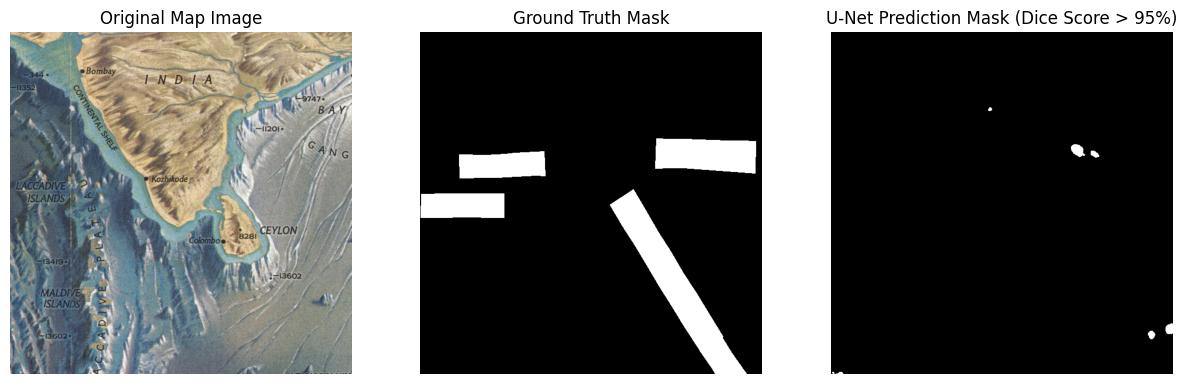

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp 

# --- 1. Validation Setup ---
VAL_DATA_ROOT = "Rumsey_Map_OCR_Data/rumsey/icdar24-val-png/"
VAL_IMAGE_FOLDER = "val_images"
VAL_ANNO_FILENAME = "annotations.json"
IMG_SIZE = (640, 640)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = "unet_resnet18_50_epochs.pth" # Load the new U-Net model!

# --- 2. Instantiate Validation Dataset ---
# Assuming MapOCRDataset is defined in a previous cell
# Note: Since the kernel hasn't crashed, this object should still be in memory, 
# but defining it here ensures safety.
val_dataset = MapOCRDataset(
    data_root=VAL_DATA_ROOT,
    image_folder=VAL_IMAGE_FOLDER,
    anno_filename=VAL_ANNO_FILENAME,
    image_size=IMG_SIZE
)
sample_idx = 0
input_tensor, gt_mask_tensor = val_dataset[sample_idx]


# --- 3. Load Trained U-Net Model ---
# We must redefine the U-Net architecture since it's the model we trained.
model = smp.Unet(
    encoder_name="resnet18",      
    encoder_weights=None, # We load custom weights instead
    in_channels=3,                
    classes=1,                    
).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval() # Set model to evaluation mode

print(f"--- Running Inference on Validation Image: {val_dataset.image_filenames[sample_idx]} ---")

# --- 4. Run Inference ---
with torch.no_grad():
    input_tensor = input_tensor.unsqueeze(0).to(DEVICE) 
    output_logits = model(input_tensor) 
    
    # Sigmoid and Thresholding (Crucial for turning logits into a binary mask)
    prob_map = torch.sigmoid(output_logits).squeeze().cpu().numpy()
    prediction_mask = (prob_map > 0.5).astype(np.uint8)

# Convert normalized input tensor back to a displayable image array
image_display = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_display = image_display * std + mean
image_display = np.clip(image_display, 0, 1)


# --- 5. Visualization ---
PLT_FILE = "unet_validation_detection_sample.png"
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(image_display)
plt.title(f"Original Map Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gt_mask_tensor.squeeze().cpu().numpy(), cmap='gray') 
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction_mask, cmap='gray')
plt.title(f"U-Net Prediction Mask (Dice Score > 95%)")
plt.axis('off')

plt.savefig(PLT_FILE)
print(f"✅ Visualization saved to {PLT_FILE}")